In [1]:
#TITLE OF ML PROJECT: IN-VEHICLE COUPON RECOMMENDATION

In [2]:
#NAME: GAYATHRI GIRISH
#ORGANISATION: ENTRI ELEVATE
#DATE:

In [3]:
#1.OVERVIEW OF THE PROBLEM:
#This data was collected via a survey on Amazon Mechanical Turk. The survey describes different drivingscenarios including the destination, current time, weather, passenger, etc., and then ask the person whether they will accept the coupon if they are the driver.

In [4]:
#2.OBJECTIVE:
#The goal is to find whether a person will accept the coupon recommended to him in different driving scenarios.

In [5]:
#3.DATA DESCRIPTION
#SOURCE: UCI REPOSITORY
#FEATURES:

In [6]:
import pandas as pd
import numpy as np

In [7]:
#DATA COLLECTION
data = pd.read_csv("jupyter/in-vehicle-coupon-recommendation.csv")

In [16]:
#DATA EXPOLRATION

In [17]:
unique_values_summary = {col: {"unique_values": data[col].unique(), "count": data[col].nunique()} for col in data.columns}

In [18]:
stats_summary = data.describe()

In [19]:
renamed_data = data.rename(
    columns=lambda x: x.strip().lower().replace(" ", "_").replace("(", "").replace(")", "")
)

In [21]:
print("Unique Values Summary:", unique_values_summary)

Unique Values Summary: {'Destination': {'unique_values': array(['No Urgent Place', 'Home', 'Work'], dtype=object), 'count': 3}, 'Passenger': {'unique_values': array(['Alone', 'Friend(s)', 'Kid(s)', 'Partner'], dtype=object), 'count': 4}, 'weather': {'unique_values': array(['Sunny', 'Rainy', 'Snowy'], dtype=object), 'count': 3}, 'temperature': {'unique_values': array([55, 80, 30]), 'count': 3}, 'time': {'unique_values': array(['2PM', '10AM', '6PM', '7AM', '10PM'], dtype=object), 'count': 5}, 'coupon': {'unique_values': array(['Restaurant(<20)', 'Coffee House', 'Carry out & Take away', 'Bar',
       'Restaurant(20-50)'], dtype=object), 'count': 5}, 'expiration': {'unique_values': array(['1d', '2h'], dtype=object), 'count': 2}, 'gender': {'unique_values': array(['Female', 'Male'], dtype=object), 'count': 2}, 'age': {'unique_values': array(['21', '46', '26', '31', '41', '50plus', '36', 'below21'],
      dtype=object), 'count': 8}, 'maritalStatus': {'unique_values': array(['Unmarried partne

In [22]:
print("Statistical Summary:", stats_summary)

Statistical Summary:         temperature  has_children  toCoupon_GEQ5min  toCoupon_GEQ15min  \
count  12684.000000  12684.000000           12684.0       12684.000000   
mean      63.301798      0.414144               1.0           0.561495   
std       19.154486      0.492593               0.0           0.496224   
min       30.000000      0.000000               1.0           0.000000   
25%       55.000000      0.000000               1.0           0.000000   
50%       80.000000      0.000000               1.0           1.000000   
75%       80.000000      1.000000               1.0           1.000000   
max       80.000000      1.000000               1.0           1.000000   

       toCoupon_GEQ25min  direction_same  direction_opp             Y  
count       12684.000000    12684.000000   12684.000000  12684.000000  
mean            0.119126        0.214759       0.785241      0.568433  
std             0.323950        0.410671       0.410671      0.495314  
min             0.000000

In [23]:
#DATA CLEANING

In [35]:
# Replace "0" in age with NaN
renamed_data['age'] = renamed_data['age'].replace('0', pd.NA)

In [36]:
# Handle missing values
categorical_cols = renamed_data.select_dtypes(include=['object']).columns
numerical_cols = renamed_data.select_dtypes(exclude=['object']).columns

In [26]:
from sklearn.impute import KNNImputer

In [37]:
# Fill missing values
knn_imputer = KNNImputer(n_neighbors=5)

In [38]:
X_filled = knn_imputer.fit_transform(renamed_data.select_dtypes(include=['float64', 'int64']))

In [39]:
numerical_filled = pd.DataFrame(X_filled, columns=renamed_data.select_dtypes(include=['float64', 'int64']).columns)
renamed_data.update(numerical_filled)

In [40]:
# Remove duplicate rows
renamed_data = renamed_data.drop_duplicates()

In [41]:
# Detect and cap outliers using the IQR metho
Q1 = renamed_data[numerical_cols].quantile(0.25)
Q3 = renamed_data[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

In [42]:
# Define acceptable range and cap outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
for col in numerical_cols:
    renamed_data[col] = renamed_data[col].clip(lower=lower_bound[col], upper=upper_bound[col])


In [43]:
# Save cleaning results
print("Data Cleaning Completed!")

Data Cleaning Completed!


In [44]:
#EDA

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
# Filter data with age > 40 and income < 5000
renamed_data['age'] = renamed_data['age'].replace({'below21': '20', '50plus': '50'}).astype(int)
income_map = {
    "Less than $12500": 6250, "$12500 - $24999": 18750, "$25000 - $37499": 31250,
    "$37500 - $49999": 43750, "$50000 - $62499": 56250, "$62500 - $74999": 68750,
    "$75000 - $87499": 81250, "$87500 - $99999": 93750, "$100000 or More": 100000
}
renamed_data['income'] = renamed_data['income'].replace(income_map)
filtered_data = renamed_data[(renamed_data['age'] > 40) & (renamed_data['income'] < 5000)]


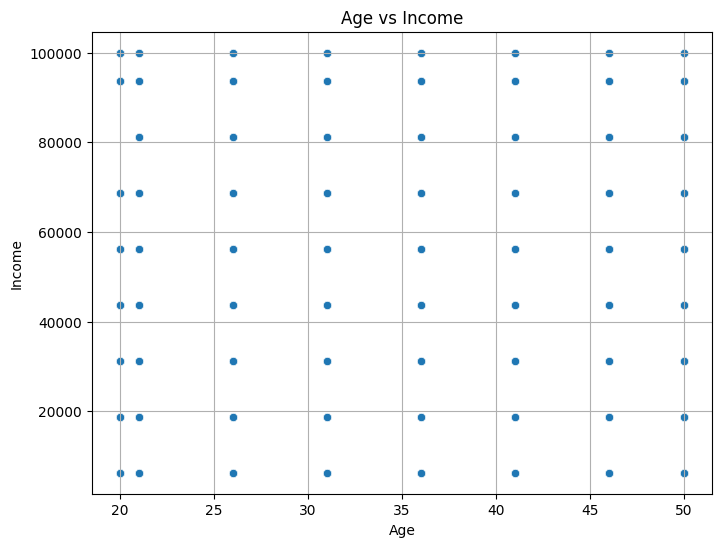

In [49]:
# Plot Age vs Income
plt.figure(figsize=(8, 6))
sns.scatterplot(x=renamed_data['age'], y=renamed_data['income'])
plt.title('Age vs Income')
plt.xlabel('Age')
plt.ylabel('Income')
plt.grid()
plt.show()

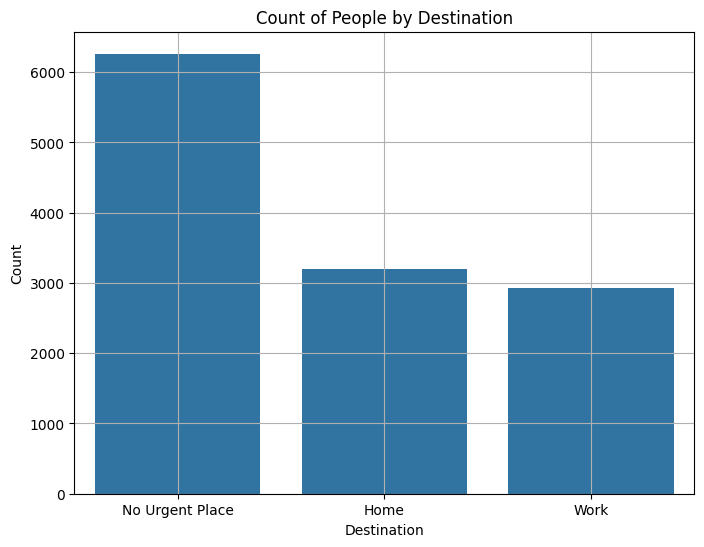

In [50]:
# Count people by destination
destination_counts = renamed_data['destination'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=destination_counts.index, y=destination_counts.values)
plt.title('Count of People by Destination')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.grid()
plt.show()

In [51]:
#DATA ENCODING

In [52]:
encoded_data = pd.get_dummies(renamed_data, drop_first=True)

In [53]:
print("Categorical Variables Encoded!")

Categorical Variables Encoded!


In [54]:
#FEATURE SELECTION

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [57]:
# Encode the target variable 
label_encoder = LabelEncoder()
renamed_data['y'] = label_encoder.fit_transform(renamed_data['y'])

In [58]:
# Define features (X) and target (y)
X = renamed_data.drop(['y'], axis=1)  # Drop the target column
y = renamed_data['y']


In [59]:
X = pd.get_dummies(X, drop_first=True)

In [60]:
# Split into training and testing datasets (for random forest selection)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
#Random Forest Feature Importance

In [66]:
# Fit a Random Forest model
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [67]:
# Get feature importances
feature_importances = random_forest.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

In [68]:
# Select features with high importance
top_features_rf = importance_df[importance_df['Importance'] > 0.01]  

In [69]:
print("Top Features Selected by Random Forest:")
print(top_features_rf)

Top Features Selected by Random Forest:
                                             Feature  Importance
3                                             income    0.058056
1                                                age    0.051732
0                                        temperature    0.045678
24                                     expiration_2h    0.038941
5                                  tocoupon_geq15min    0.031286
21                               coupon_Coffee House    0.028912
18                                          time_6PM    0.027089
20                      coupon_Carry out & Take away    0.024919
9                        destination_No Urgent Place    0.021924
2                                       has_children    0.021537
23                            coupon_Restaurant(<20)    0.021349
81                            restaurant20to50_less1    0.020537
11                               passenger_Friend(s)    0.020369
15                                     weather_Sun

In [70]:
#SelectKBest Feature Selection

In [71]:
# Use SelectKBest with ANOVA F-test
k_best = SelectKBest(score_func=f_classif, k=10)  # Choose top 10 features
k_best.fit(X_train, y_train)

C:\Users\Asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [4 6 7 8] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


SelectKBest()

In [72]:
# Get the selected features
selected_features = X_train.columns[k_best.get_support()]

In [73]:
print("Top Features Selected by SelectKBest:")
print(selected_features)

Top Features Selected by SelectKBest:
Index(['temperature', 'has_children', 'tocoupon_geq15min', 'time_2PM',
       'coupon_Coffee House', 'coupon_Restaurant(<20)', 'expiration_2h',
       'maritalstatus_Single', 'bar_never', 'coffeehouse_never'],
      dtype='object')


In [74]:
#Remove Redundant or Irrelevant Features

In [75]:
# Filter dataset to keep only selected features from both methods
final_features = list(set(top_features_rf['Feature']).union(selected_features))  # Combine both methods
X_selected = X[final_features]


In [76]:
print("Final Selected Features:", final_features)

Final Selected Features: ['coupon_Coffee House', 'occupation_Sales & Related', 'destination_No Urgent Place', 'maritalstatus_Married partner', 'time_10PM', 'has_children', 'carryaway_less1', 'tocoupon_geq15min', 'age', 'education_Graduate degree (Masters or Doctorate)', 'time_6PM', 'destination_Work', 'coffeehouse_less1', 'bar_less1', 'weather_Sunny', 'restaurantlessthan20_4~8', 'passenger_Friend(s)', 'coupon_Carry out & Take away', 'restaurant20to50_never', 'coffeehouse_never', 'education_Bachelors degree', 'gender_Male', 'restaurantlessthan20_less1', 'time_2PM', 'occupation_Computer & Mathematical', 'weather_Snowy', 'coffeehouse_4~8', 'coupon_Restaurant(20-50)', 'maritalstatus_Single', 'carryaway_4~8', 'education_Some college - no degree', 'temperature', 'income', 'expiration_2h', 'occupation_Unemployed', 'carryaway_gt8', 'bar_never', 'restaurant20to50_less1', 'time_7AM', 'passenger_Partner', 'passenger_Kid(s)', 'coupon_Restaurant(<20)', 'maritalstatus_Unmarried partner']
